In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import folium

# Chlorophyll-a Concentration Prediction Project

## Objective

This project aims to predict chlorophyll-a concentrations in seawater using the CalCOFI dataset. Accurate prediction of chlorophyll-a levels will enable fishing companies to identify high-productivity zones, optimizing their operations.

## Scope

In this project, we will exclusively focus on testing and evaluating the performance of polynomial regression models. This will include:

- Data exploration and preparation.
- Implementation of polynomial regression with different polynomial degrees.
- Use of regularization techniques such as ridge, lasso, and elastic net.
- Application of cross-validation and grid search methods to find the best hyperparameters.

## Justification

The choice of polynomial regression as the main method is due to its ability to capture non-linear relationships between the predictor variables and the target variable (chlorophyll-a concentration). Additionally, using regularization will help prevent overfitting and improve model generalization.

## Methodology

1. **Exploratory Data Analysis (EDA)**: We will evaluate the distribution of variables, identify and handle missing values, and explore relationships between variables.
2. **Data Preparation**: Data cleaning and transformation, creation of polynomial features, and normalization.
3. **Model Training**: Training polynomial regression models with different degrees, applying regularization and cross-validation.
4. **Model Evaluation**: Assessing model performance using appropriate metrics such as Mean Squared Error (MSE) and R-squared (R²).

This systematic approach will allow us to identify the most suitable polynomial regression model for predicting chlorophyll-a concentration, thereby optimizing fishing operations.



# Business Case: Optimizing Fishing Operations through Chlorophyll-a Prediction

## Objective

Develop a predictive model to estimate chlorophyll-a concentrations in seawater to help fishing companies identify high-productivity zones. Accurate predictions of chlorophyll-a levels will enable more efficient allocation of fishing resources, reduce operational costs, and maximize fish yields.

## Problem Statement

Fishing companies face significant challenges in locating areas with high fish density. Current methods are often time-consuming and costly, leading to inefficiencies and higher operational costs. By predicting chlorophyll-a concentration, which is a key indicator of phytoplankton abundance, companies can better target their fishing efforts.

## Data Source

The California Cooperative Oceanic Fisheries Investigations (CalCOFI) dataset, which includes comprehensive measurements of oceanographic and environmental variables such as:

- Depth (Depthm)
- Water temperature (T_degC)
- Salinity (Salnty)
- Nutrient concentrations (e.g., nitrate NO3uM, phosphate PO4uM, silicate SiO3uM)

## Potential Predictors

To build a robust predictive model, the following variables could be considered as potential predictors:

- Environmental Variables: Depth, water temperature, salinity
- Chemical Variables: Concentrations of nitrate, phosphate, silicate, and dissolved oxygen
- Geographic and Temporal Variables: Latitude, longitude, time of year (month, season)

## Expected Outcome

By leveraging this model, fishing companies will be able to:

- Identify and prioritize high-yield fishing zones based on predicted chlorophyll-a levels.
- Optimize fishing routes and schedules, reducing fuel consumption and operational time.
- Increase fish yields by targeting areas with higher biological productivity.
- Enhance decision-making processes with data-driven insights into oceanographic conditions.

## Impact

Implementing this predictive model will lead to:

- Cost savings through more efficient resource allocation.
- Higher profitability due to increased fish yields.
- Reduced environmental impact by minimizing unnecessary fishing efforts.


In [9]:
# This datasets are not in the repo, you can download it from the kaggle webpage
# https://www.kaggle.com/datasets/sohier/calcofi
# Also we are going to be working with the variable description provided by the
# CalCOFI webpage: https://calcofi.org/data/oceanographic-data/bottle-database/

bottle = pd.read_csv("datasets/calcofi/bottle.csv")
cast = pd.read_csv("datasets/calcofi/cast.csv")

/tmp/ipykernel_2883/32580813.py:6: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle = pd.read_csv("datasets/calcofi/bottle.csv")
/tmp/ipykernel_2883/32580813.py:7: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast = pd.read_csv("datasets/calcofi/cast.csv")


------

# Data Exploration

In this section, we will explore the dataset to understand its structure, identify missing values, and visualize relationships between variables.


In [10]:
# Let's work on a random sample of the dataset
# the parameter random_state should be used to get 
# same results in different executions of the code 

bottle = bottle.sample(n=10000, random_state=42)

First lets take a quick view over the objective variable 

In [19]:
print("\n\n\n#########.info()#############\n\n\n")
print(bottle["ChlorA"].info())
print("\n\n\n#########.sample(10)#############\n\n\n")
print(bottle["ChlorA"][bottle["ChlorA"].notna()].sample(10))
print("\n\n\n#########.describe()#############\n\n\n")
print(bottle["ChlorA"].describe())




#########.info()#############



<class 'pandas.core.series.Series'>
Index: 10000 entries, 246454 to 893
Series name: ChlorA
Non-Null Count  Dtype  
--------------  -----  
2602 non-null   float64
dtypes: float64(1)
memory usage: 156.2 KB
None



#########.sample(10)#############



841379    0.097
799866    0.690
550350    0.020
722984    0.170
519247    0.380
615546    0.100
834113    0.210
799322    1.860
526864    0.820
785642    2.960
Name: ChlorA, dtype: float64



#########.describe()#############



count    2602.000000
mean        0.473914
std         1.341153
min         0.000000
25%         0.050000
50%         0.150000
75%         0.390000
max        22.530000
Name: ChlorA, dtype: float64


1. The variable is numeric, stored in a float64 dtype and has a minimum of 0, maximum of 22.53 and a mean of 0.47. This kind of value is ideal for regression analysis!
2. If the mean is 0.47 and the std is 1.34, the maximum of 22,53 is clearly an outlier, we'll check it out later.
3. Just 26 percent of the rows contain values, that's a significant ammount of null values in the dataset. Before decide what to do with those null values, we should try to know more about the reason of those nulls.

Let's start looking at the big picture. We have two datasets: cast and bottle. 
**What is a bottle?** This is the answer from the CalCOFI website:

> **History of CalCOFI Seawater Sample Collection** <br> Prior to 1993, CalCOFI collected seawater samples using Niskin, Nansen, and “Wally” (in-house design by Walt Bryant & George Anderson) bottles with reversing thermometers. In 1990, CalCOFI began using a CTD-Rosette (pictured here underwater), and starting Aug 1993 (9308NH) CTD-Rosette sampling became the primary method of seawater collection. ![Example](https://calcofi.org/wp-content/uploads/2020/03/1904RL_sta93-50_CTDSurface-1024x770.jpg)


> - The Cast table contains metadata. This table includes date, time, latitude, longitude, weather, etc. for each CTD cast ever completed on a CalCOFI cruise. Each row is a unique cast, numbered sequentially/indexed by the “Cst_Cnt” column.
> - The Bottle table contains oceanographic data. This table includes oceanographic measurements for each bottle/sampling depth ever completed on a CalCOFI cruise. There are additional data code and precision columns describing the quality of each oceanographic measurement. Each row is a unique bottle/sampling depth, numbered sequentially/indexed by the “Btl_Cnt” column.
> - This table is much larger than the Cast table because each cast can have up to 24 bottles/sampling depths.
> - The Bottle table also has a “Cst_Cnt” column, which can be used as a unifier between the two tables.


Then cast seems to be the big device in the image which holds the bottles, also see that the bottles are numerated until 24 and then starts over in 1 as the description says. Also bottle dataset contains is each of those bottles in the cast. Then lets see if the null values of our objective variable `ChlorA` is related with some of the attributes of the casts. 

In [24]:
# Join bottle and cast datasets but just using the key to join the datasets and the objective value of bottle
obj_bottle = bottle[["ChlorA", "Cst_Cnt"]].merge(cast, how='inner', on="Cst_Cnt")

In [35]:
# Create a new boolean variable to check if the value of ChlorA is null 
obj_bottle["ChlorA_isna"] = obj_bottle["ChlorA"].isna()

First I want to check if there is a relationship between the null values and the moment of the year.

<Axes: xlabel='Quarter', ylabel='count'>

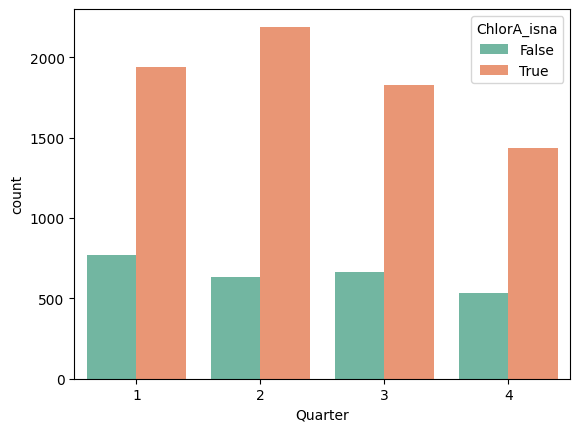

In [36]:
sns.countplot(x='Quarter', data=obj_bottle, hue='ChlorA_isna', palette='Set2')

Seems that there is not relationship. Now I want to check if is related with the location of the cast. Let's see what could be the most appropiate variables to see the location.

In [38]:
list_location_variables = ['Lat_Dec',
'Lat_Deg',
'Lat_Min',
'Lat_Hem',
'Lon_Dec',
'Lon_Deg',
'Lon_Min',
'Lon_Hem',]

obj_bottle[list_location_variables]

,Lat_Dec,Lat_Deg,Lat_Min,Lat_Hem,Lon_Dec,Lon_Deg,Lon_Min,Lon_Hem
0,25.316666,25,19.0,N,-114.433333,-114,26.0,W
1,22.741666,22,44.5,N,-111.950000,-111,57.0,W
2,37.616666,37,37.0,N,-123.125000,-123,7.5,W
3,23.758333,23,45.5,N,-114.291666,-114,17.5,W
4,33.216666,33,13.0,N,-121.500000,-121,30.0,W
...,...,...,...,...,...,...,...,...
9995,20.000000,20,0.0,N,-125.000000,-125,0.0,W
9996,32.675000,32,40.5,N,-117.858333,-117,51.5,W
9997,37.625000,37,37.5,N,-123.616666,-123,37.0,W
9998,30.900000,30,54.0,N,-122.183333,-122,11.0,W


Seems that `Lat_Dec` and `Lon_Dec` are the most appropiate variables, let's plot them and compare with our objective variable

In [46]:
# I want to see the non null value first in the plot
obj_bottle = obj_bottle.sort_values(by='ChlorA_isna', ascending=False)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

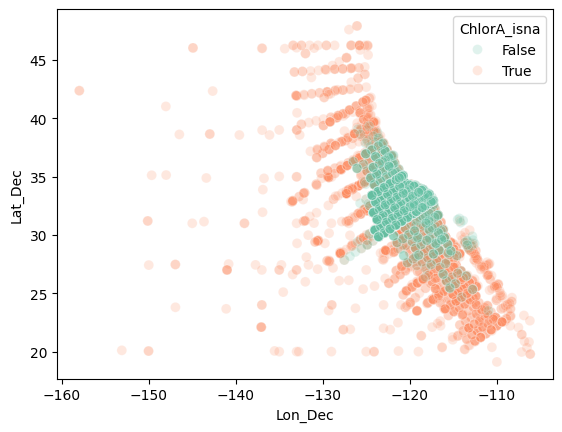

In [49]:
sns.scatterplot(x='Lon_Dec', y='Lat_Dec', hue='ChlorA_isna', data=obj_bottle, palette='Set2', alpha=0.2, s=50)

There is a clear relationship between the location and the null values! That white blank close to the center of the most common casts seems to be The Baja California Peninsula, lets try to plot it into a map.

In [62]:
def assign_color(category):
    if category:
        return 'grey'
    else:
        return 'red'

In [65]:
map_center = [obj_bottle['Lat_Dec'].mean(), obj_bottle['Lon_Dec'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)
for i in obj_bottle.index:
    folium.CircleMarker(
        location=[obj_bottle.loc[i, 'Lat_Dec'], obj_bottle.loc[i, 'Lon_Dec']],
        radius=1,
        color=assign_color(obj_bottle.loc[i, 'ChlorA_isna']),
        fill=True,
        fill_color=assign_color(obj_bottle.loc[i, 'ChlorA_isna']),
        popup=obj_bottle.loc[i, 'ChlorA_isna']
    ).add_to(mymap)

mymap.save('images/my_map.html')

Folium returns an HTML file containing the map; for convenience, we provide a static copy here. As we can see, that blank part in the previous plot was indeed the Baja California Peninsula. There seems to be a relationship between distance from LA and null values in the `ChlorA` variable. ![here](images/bottlemap.png)